In [5]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import pingouin as pg

# Задание 1
### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [11]:
df_reg = pd.read_csv('~/shared/problem1-reg_data.csv',sep = ";")

In [12]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [13]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [14]:
df_reg.shape

(1000000, 2)

In [15]:
#все пользователи уникальные 
df_reg['uid'].nunique()

1000000

In [16]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [17]:
df_auth = pd.read_csv('~/shared/problem1-auth_data.csv',sep = ";")

In [18]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [19]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [20]:
df_auth.shape

(9601013, 2)

In [21]:
df_auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [22]:
# количество дубликатов
len(df_auth['uid']) - len(df_auth['uid'].drop_duplicates())

8601013

In [23]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [24]:
def calculate_retention(df_reg,df_auth,start_date,end_date):
    
    """Функция расчитывает retention по дням. На вход принимает 2 датафрейма, дата начала и конца."""
    
    
    #Переводим даты из unix формата в datetime
    df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'],unit = 's')
    df_reg['reg_ts'] = df_reg.reg_ts.dt.strftime("%Y-%m-%d")
    df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'])
    
    
    df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'],unit = 's')
    df_auth['auth_ts'] = df_auth.auth_ts.dt.strftime("%Y-%m-%d")
    df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'])
    
     #Фильтруем данные по дате начала и конца 
    reg_filtered = df_reg[(df_reg['reg_ts'] >= start_date) & (df_reg['reg_ts'] <= end_date)]
    auth_filtered = df_auth[(df_auth['auth_ts'] >= start_date) & (df_auth['auth_ts'] <= end_date)]

    #Объединяем 2 датафрейма 
    retention = reg_filtered.merge(auth_filtered,how = 'left', on = 'uid')
    
    #Группируем дф по датам и считаем уникальных пользователей 
    cohort_ret = retention.groupby(['reg_ts','auth_ts'],as_index = False) \
    .agg({'uid':'nunique'}) \
    .sort_values(['reg_ts','auth_ts'],ascending = False)
    
     #Затем считаем разницу в днях с момента захода в игру и датой регистрации
    cohort_ret['retention_day'] = (cohort_ret['auth_ts'] - cohort_ret['reg_ts']).dt.days
    
    #Делаем пивот таблицу и считаем retention в процентах
    ret_table = cohort_ret.pivot_table(index='reg_ts', columns='retention_day', values='uid') 
    total_players = ret_table.iloc[:, 0]  
    retention_percentage = ret_table.div(total_players, axis=0) 
    
    #Визуализируем
    plt.figure(figsize=(21, 13))
    sns.heatmap(retention_percentage, annot=True, fmt="1.0%", cmap="YlGnBu")
    plt.title('Retention Heatmap')
    plt.xlabel('Days Since Registration')
    plt.ylabel('Registration Date')
    plt.show()

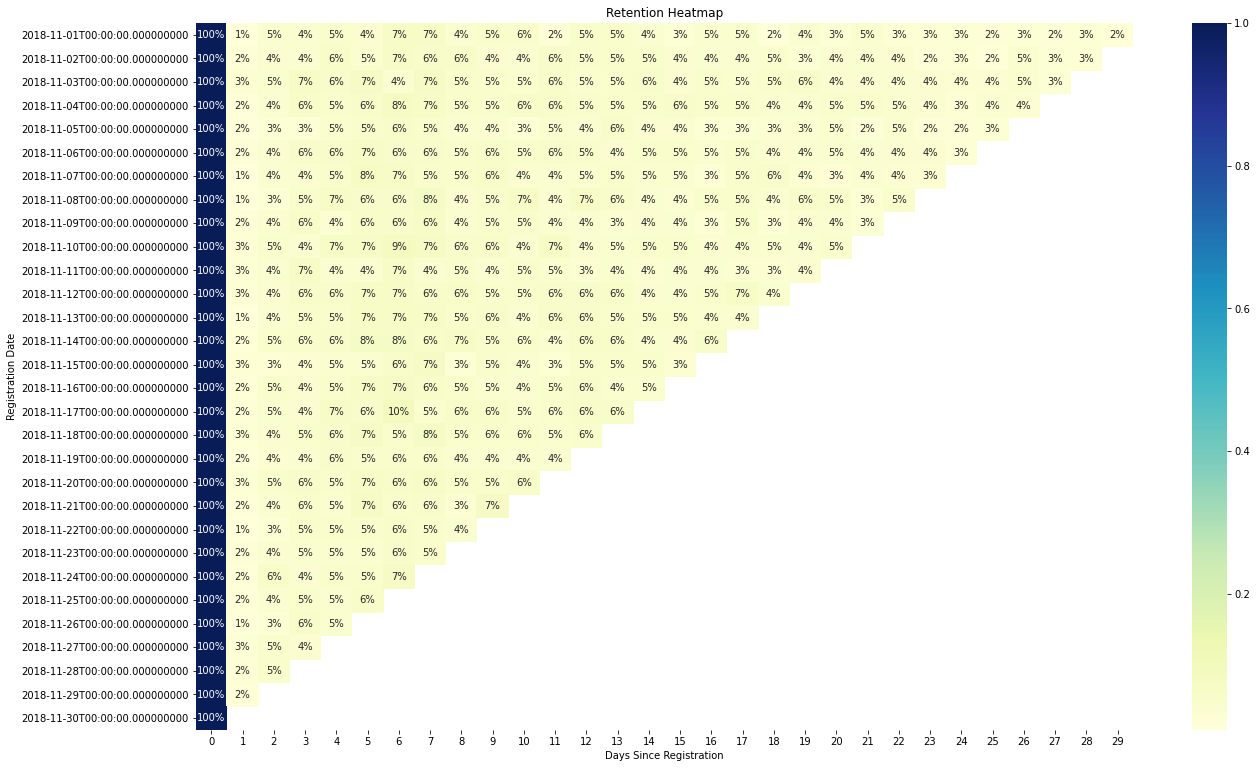

In [25]:
calculate_retention(df_reg, df_auth,start_date = pd.Timestamp("2018-11-01"),end_date = pd.Timestamp("2018-11-30"))

# Задание 2 
### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. 
### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [26]:
df = pd.read_csv('Проект_1_Задание_2.csv',sep = ";")

In [27]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


### Анализ данных

In [28]:
df_a = df.query('testgroup == "a"')

In [29]:
df_a

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [30]:
df_a.revenue.min()

0

In [31]:
df_a.revenue.max()

37433

In [32]:
a_mean = np.mean(df_a.revenue)
a_median = np.median(df_a.revenue)
print(f"testgroup a: mean = {a_mean}, median = {a_median}")

testgroup a: mean = 25.413719736965806, median = 0.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


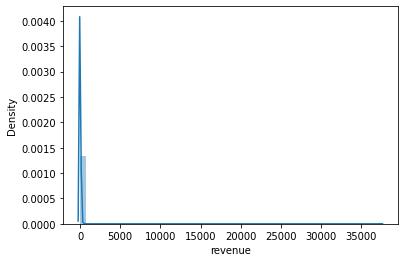

In [33]:
sns.distplot(df_a.revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


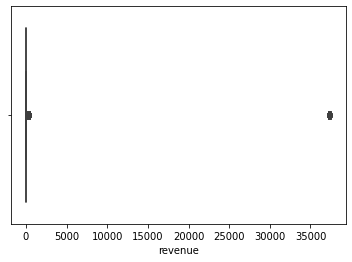

In [34]:
sns.boxplot(df_a.revenue)

In [35]:
df_b = df.query('testgroup == "b"')

In [36]:
df_b

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


In [37]:
df_b.revenue.min()

0

In [38]:
df_b.revenue.max()

4000

In [39]:
b_mean = np.mean(df_b.revenue)
b_median = np.median(df_b.revenue)
print(f"testgroup b: mean = {b_mean}, median ={b_median}")

testgroup b: mean = 26.75128659327863, median =0.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


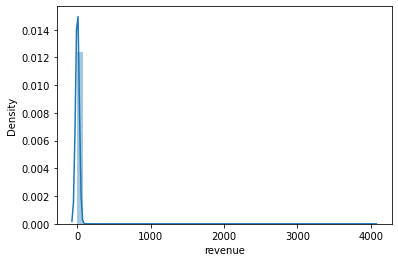

In [40]:
sns.distplot(df_b.revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


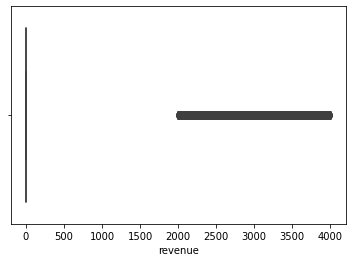

In [41]:
sns.boxplot(df_b.revenue)

## Проверяем данные на нормальность


In [42]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


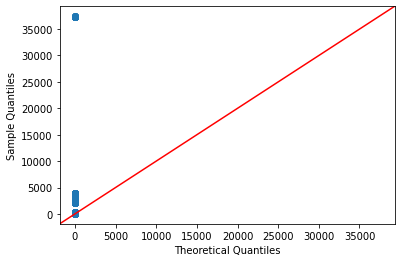

In [43]:
fig = sm.qqplot(df.revenue,line = '45')
plt.show()

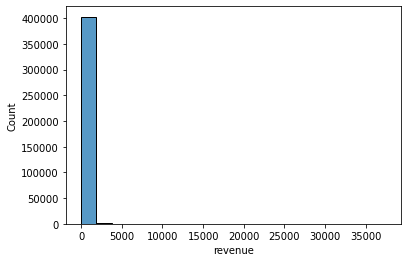

In [44]:
sns.histplot(df.revenue)

In [45]:
#тест Шапиро-Уилка
stats.shapiro(df.revenue)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.015135347843170166, pvalue=0.0)

In [46]:
#тест Колмогорова-Смирнова
stats.kstest(df.revenue, 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

## Проверим данные на равенство диспресии


In [47]:
#тест Левена
stats.levene(df_a.revenue,df_b.revenue, center='mean')

LeveneResult(statistic=1.57736044973474, pvalue=0.2091420343022563)

#### Обе группы имеют равные распределения

## H0 - средний revenue в тестовой и контрольной группе не отличаются 
### Для проверки будем использовать t-test и bootstrap

In [48]:
# t-test
stats.ttest_ind(df_a.revenue,df_b.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

In [49]:
#bootstrap
ci_control = pg.compute_bootci(df_a.revenue, func = 'mean', n_boot = 1000)
ci_test = pg.compute_bootci(df_b.revenue, func = 'mean', n_boot = 1000)

# Проверяем перекрываются ли интервалы или нет
if ci_control[1] < ci_test[0] or ci_test[1] < ci_control[0]:
    print("Различия в средних значениях статистически значимы")
else:
    print("Нет статистически значимых различий в средних значениях")

Нет статистически значимых различий в средних значениях


### H0 подтвердилась: средние значение revenue в обеих группах статистически значимо не отличаются 

## Теперь посмотрим только на платящих пользователей 

In [50]:
paid_df = df.query('revenue > 0')

In [51]:
paid_df_a = paid_df.query('testgroup == "a"')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


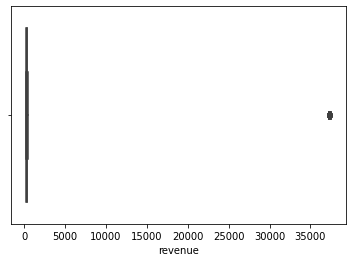

In [52]:
sns.boxplot(paid_df_a.revenue)

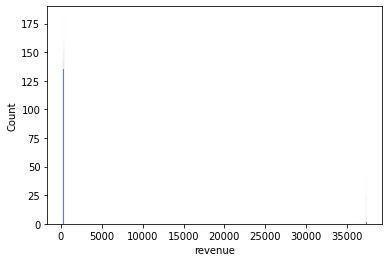

In [53]:
sns.histplot(paid_df_a.revenue)

In [54]:
paid_df_a.shape[0]

1928

In [55]:
paid_df_b = paid_df.query('testgroup == "b"')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


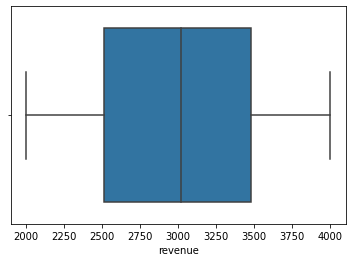

In [56]:
sns.boxplot(paid_df_b.revenue)

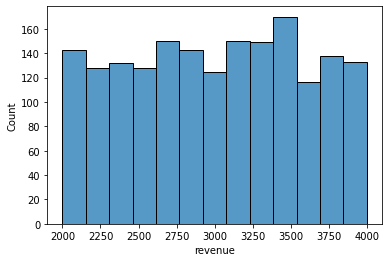

In [57]:
sns.histplot(paid_df_b.revenue)

In [58]:
paid_df_b.shape[0]

1805

In [59]:
diff = paid_df_a.shape[0] - paid_df_b.shape[0]
print(f"В контрольной группе больше платящих пользователей на {diff}")

В контрольной группе больше платящих пользователей на 123


## H0 - ARPU в тестовой и контрольной группе равны
### Проверю дисперсию 2 групп 

In [60]:
#тест Левена на среднем
stats.levene(paid_df_a.revenue,paid_df_b.revenue, center='mean')

LeveneResult(statistic=445.9869447066088, pvalue=1.3202514573715939e-93)

In [61]:
#тест Левена на медиане
stats.levene(paid_df_a.revenue,paid_df_b.revenue, center='median')

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

#### Тест Левена показал, что дисперсия в группах разная, поэтому для проверки средних будем использовать t-test Уэлча и bootstrap 

In [62]:
# t-тест Уэлча
stats.ttest_ind(paid_df_a.revenue,paid_df_b.revenue,equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

In [63]:
#bootstrap
ci_control = pg.compute_bootci(df_a.revenue, func = 'mean', n_boot = 1000)
ci_test = pg.compute_bootci(df_b.revenue, func = 'mean', n_boot = 1000)

# Проверяем перекрываются ли интервалы или нет
if ci_control[1] < ci_test[0] or ci_test[1] < ci_control[0]:
    print("Различия в средних значениях статистически значимы")
else:
    print("Нет статистически значимых различий в средних значениях")

Нет статистически значимых различий в средних значениях


### H0 подтвердилась: ARPU  в двух группах стат. значимо не отличаются 

### Последнее, что хочу проверить это конверсию в контрольной и тестовой группе
### H0 - конверсия в обеих группах равна 

In [64]:
# 1 число - сконвертировавшиеся пользователи, 2 число - общее количество пользователей
a_converted_control, a_total_control = 1928, 202103
b_converted_test, b_total_test = 1805, 202667

In [65]:
# z-тест для долей
sm.stats.proportions_ztest([a_converted_control, b_converted_test], [a_total_control, b_total_test])

(2.108028495889841, 0.035028524642854865)

#### Существуют стат. значимые различия в конверсии у 2 групп

In [66]:
conversion_a = round(((paid_df_a.shape[0] / df_a.shape[0]) * 100), 2)
print(f"Конверсия в контрольной группе равна {conversion_a} %")

Конверсия в контрольной группе равна 0.95 %


In [67]:
conversion_b = round(((paid_df_b.shape[0] / df_b.shape[0]) * 100), 2)
print(f"Конверсия в тестовой группе равна {conversion_b} %")

Конверсия в тестовой группе равна 0.89 %


## Выводы:
### Тесты показали, что нет стат. значимых различий средних revenue в контрольной и тестовой группе 
### При исследовании ARPU также не было выявлено стат. значимых различий
### Опираясь на резулатьты исследования, можно сделать вывод, что мы отклоняем тестовый вариант акционных предложений, потому что показатели контрольной и тестовой группы одинаковы, при этом конверсия в контрольной группе выше

# Задание 3
### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?
#### 1) Retention показывает, как пользователи возвращаются в игру и часто свидетельствует о том, нравиться ли игрокам новое тематическое событие или нет.
#### 2) Сhurn rate позволяет взглянуть на проблемы и причины, из-за которых игроки перестали заходить в игру, возможно им не понравилось новое тематическое событие или были баги во время прохождения уровней.
#### 3) DAU и MAU. С помощью этих метрик можно понять сколько уникальных игроков заходят в игру каждый день/месяц, но сами по себе эти метрики мало что дают, поэтому их нужно сравнивать со значениями предыдущих тематических событий.
#### 4) K-factor покажет на сколько тематическое событие виральное: сколько в среднем один активный пользователь приводит в игру новых пользователей. Если тематическое событие понравилось игроку, он обязательно расскажет об этом кому-то, например другу, а тот возможно скачает игру.
#### 5) С помощью ARPPU определим какой средний доход на платящего игрока -  пользователя, который совершил покупку во время тематического события, например, купил дополнительные монеты.
#### 6) LTV покажет доход с одного пользователя за все время тематического события.
#### 7) Под конец посчитаем ROI, для понимания на сколько прибыльно или убыточно оказалось тематическое событие в игре.
### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?
#### Я думаю изменятся, но не значительно, потому что метрики, которые мы рассмотрели выше являются стандартном для оценки игровых мобильных приложений.
#### Но дополнительно я бы рассмотрел следующие метрики:
#### 1) ASL : с помощью этой метрики можно понять, сколько люди в среднем проводят время в игре. Если ASL после усложнения механики стало ниже, то игроки меньше проводят времени в игре, соответсвенно новая механика пользователям не понравилась.
#### 2) Stickness ratio - метрика, которая помогает оценить вовлеченность игроков в тематическое событие. Она характеризует регулярность использования приложения в течение недели или месяца, то есть позволяет оценить, насколько игрокам нравится тематическое событие на основании частоты использования. 